 <img src="../code/Resources/cropped-SummerWorkshop_Header.png"> 

<h1 align="center">Homework worksheet, Day 2. Tutorial on neuronal encoding and behavior</h1> 
<h3 align="center">Summer Workshop on the Dynamic Brain</h3> 
<h3 align="center">Thursday, August 26th, 2025</h3> 
<h4 align="center">Day 2</h4> 

### Question: Does decoding performance depend on behavior states?  

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

For today's homework, we will dig a little more deeply into neural decoding and behavior states. Specifically, we are going to build on what we saw in the workshops earlier to try to see how decoding changes with behavior state.

To get started, lets grab the python packages that we might want.
</div>


In [44]:
import os
import numpy as np
import numpy.random as npr
import pandas as pd
import pynwb

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

pd.set_option('display.max_columns', None)

%matplotlib inline

from tqdm import tqdm  # Displays a smart progress bar during loops

# Sklearn
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # Standardizes features (zero mean, unit variance)

# HMM libraries 
import jax.numpy as jnp
import jax.random as jr

from dynamax.hidden_markov_model import GaussianHMM

# HMM-related imports from JAX, Dynamax, and TensorFlow Probability
from functools import partial
import jax.numpy as jnp
import jax.random as jr
from dynamax.hidden_markov_model import GaussianHMM
import tensorflow_probability.substrates.jax.distributions as tfd
from dynamax.utils.utils import find_permutation

# Additional HMM variants and plotting utilities from Dynamax
from dynamax.hidden_markov_model import (
    DiagonalGaussianHMM,
    SphericalGaussianHMM,
    SharedCovarianceGaussianHMM
)

from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

And set up the path to the data data.
</div>


In [41]:
import platform
from pathlib import Path
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = Path("/Volumes/Brain2023/")
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = Path("E:/")
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = Path("/data/")
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = Path("/media/$USERNAME/Brain2025/")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Part 0: Data wrangling.

To answer this question, you are going to need some data. The good news is that in todays workshops we already saw everything we need to do this.

</div>

In [526]:
example_session =1069461581 # Please! Pick different session!
this_session = str(example_session)
this_filename = f'ecephys_session_{this_session}.nwb'
nwb_path = data_root/'visual-behavior-neuropixels'/'behavior_ecephys_sessions'/this_session/this_filename
print(nwb_path)


/data/visual-behavior-neuropixels/behavior_ecephys_sessions/1069461581/ecephys_session_1069461581.nwb


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Lets start by reading the NWB

In [527]:
session = pynwb.NWBHDF5IO(nwb_path).read()
session

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Data type,float64
Shape,"(569336, 2)"
Array size,8.69 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(569336,)"
Array size,4.34 MiB
Chunk shape,None


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Next lets grab stimulus information

In [524]:
# Grab behavior data
trials = session.trials.to_dataframe()
stimuli = session.intervals['Natural_Images_Lum_Matched_set_ophys_H_2019_presentations'].to_dataframe()
active_stimuli = stimuli[stimuli.active==True]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

And format that information like we did in the workshop

In [498]:
# Get timestamps corresponding to go trials
go_trials = trials[trials.go]
trial_start = go_trials.start_time
trial_stop = go_trials.stop_time

behavior_data = {}

# Count licks
lick_count = go_trials.apply(lambda row : len(row['lick_times']), axis = 1)
behavior_data['lick_count'] = lick_count

# Get running speed and corresponding timestamps
running_data = session.processing['running']
running_timestamps = running_data['speed'].timestamps[:]
running_speed = running_data['speed'].data[:]
running_speed = pd.Series(running_speed).interpolate(limit_direction='both').to_numpy() 
behavior_data['running_speed']  = [np.nanmean(running_speed[np.logical_and(s1 <= running_timestamps, running_timestamps <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]


# Get pupil area and corresponding timestamps
pupil_data = session.acquisition['EyeTracking']['pupil_tracking']
pupil_timestamps = pupil_data.timestamps[:]
pupil_area = pupil_data.area[:]
pupil_area = pd.Series(pupil_area).interpolate(limit_direction='both').to_numpy() 
behavior_data['pupil_area'] = [np.nanmean(pupil_area[np.logical_and(s1 <= pupil_timestamps, pupil_timestamps <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]

behavior_df = pd.DataFrame(behavior_data)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Finally, lets pull out our units and do some basic QC.

In [499]:
# Grab electrophysiology data

# Units info
units_table = session.units.to_dataframe()
# electrode info
electrodes_table = session.electrodes.to_dataframe()
# merge unit and electrode info
units_electrode_table = units_table.join(electrodes_table,on = 'peak_channel_id')
# do quick unit QC
good_units = units_electrode_table[
    (units_electrode_table.isi_violations<.5) &
    (units_electrode_table.amplitude_cutoff<.1) &
    (units_electrode_table.presence_ratio>.95)
    ]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Part 1: Behavioral Modeling

Fit a HMM to your behavior data! Either choose a pre-defined number of states or (even better) go ahead and figure out the "best" number of states to use.
</div>

In [528]:
# Remember, this function is handy so we will keep it around:
def plot_gaussian_hmm_data(hmm, params, emissions, states, xlim=None, title = "Simulated data from an HMM"):
    """ This function should be used....
    
    Inputs:
    hmm: a hidden markov model class which we will use defined in dynamax, 
    params: a set of parameters which is carried along through training
    emissions: the observations in time
    states: the underlying latent state at each timepoint.
    """
    num_timesteps = len(emissions)
    emission_dim = hmm.emission_dim
    means = params.emissions.means[states]
    lim = 1.05 * abs(emissions).max()

    # Plot the data superimposed on the generating state sequence
    fig, axs = plt.subplots(emission_dim, 1, sharex=True, figsize = (15, 5))
    
    for d in range(emission_dim):    
        axs[d].imshow(states[None, :], aspect="auto", interpolation="none", cmap=CMAP,
                      vmin=0, vmax=len(COLORS) - 1, extent=(0, num_timesteps, -lim, lim))
        axs[d].plot(emissions[:, d], "-k")
        axs[d].plot(means[:, d], ":k")
        axs[d].set_ylabel("$y_{{t,{} }}$".format(d+1))
        
    if xlim is None:
        plt.xlim(0, num_timesteps)
    else:
        plt.xlim(xlim)

    axs[-1].set_xlabel("time")
    axs[0].set_title(title)
    plt.tight_layout()

    return fig, axs

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Part 1: Behavioral Modeling

We will get you started with some simple jpn code. </div>

In [530]:
observations = jnp.array(behavior_df.values)
num_trials, num_dimensions = observations.shape

In [531]:
# First scale the dimensions of the data to be normalized
scaler = StandardScaler()    
observations = scaler.fit_transform(observations)

In [532]:
key = jr.PRNGKey(0)
number_of_states = 2
final_hmm = GaussianHMM(number_of_states, num_dimensions, transition_matrix_stickiness=1)
params, param_props = final_hmm.initialize(key=key, method="kmeans", emissions=jnp.array(observations))
params, lps = final_hmm.fit_em(params, param_props, jnp.array(observations), num_iters=500)
most_likely_states = final_hmm.most_likely_states(params, observations)


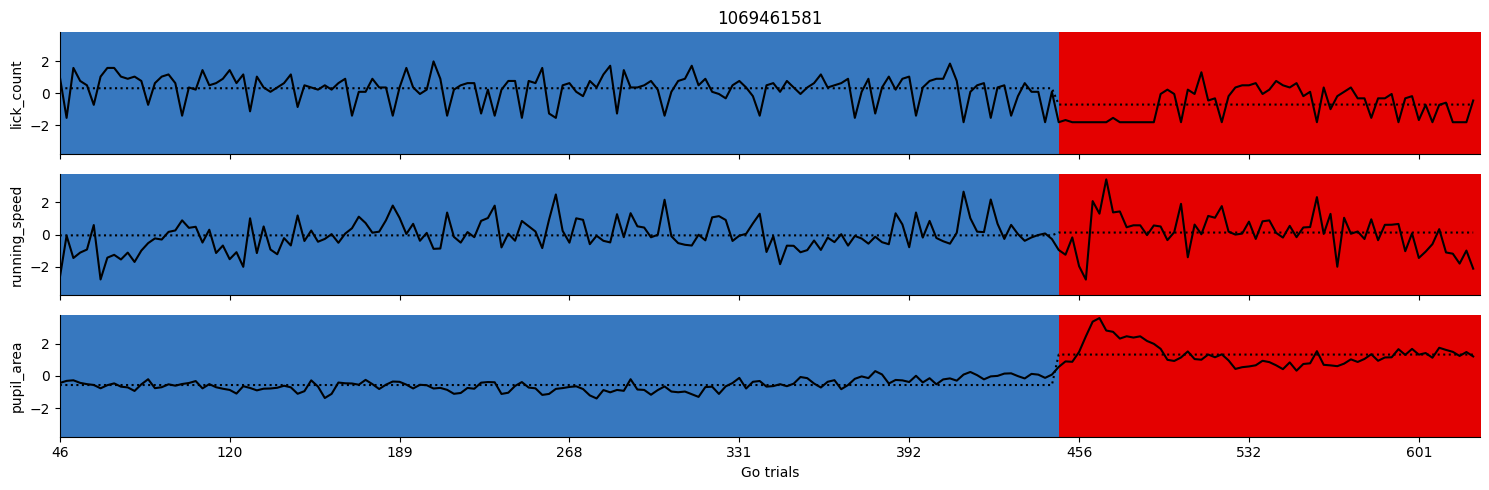

In [533]:
# Find the most likely discrete states given the learned model parameters
most_likely_states = final_hmm.most_likely_states(params, observations)
fig, axs = plot_gaussian_hmm_data(final_hmm, params, observations, most_likely_states, title = f'{this_session}')
# Formatting 
xticks = axs[0].get_xticks().astype(int)[:-1]
for n, ax in enumerate(axs):
    ax.set_xticks(xticks)
    ax.set_xticklabels(go_trials.index.values[xticks])
    ax.set_ylabel(f'{behavior_df.keys()[n]}')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
axs[-1].set_xlabel('Go trials')
plt.tight_layout()

In [513]:
from scipy.interpolate import interp1d
fx = interp1d(go_trials.start_time,most_likely_states,kind="nearest",fill_value="extrapolate")
active_stimuli['state'] = fx(active_stimuli.start_time)

/tmp/ipykernel_701/2038447313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_stimuli['state'] = fx(active_stimuli.start_time)


In [514]:
def get_binned_triggered_spike_counts_fast(spike_times, stim_times, bins):
    """
    Fast peri-stimulus time histogram using searchsorted.

    Parameters
    ----------
    spike_times : 1D array_like, sorted
        Times of all spikes (e.g. in seconds).
    stim_times : 1D array_like
        Times of stimulus onsets.
    bins : 1D array_like
        Bin edges *relative* to stimulus (e.g. np.linspace(-0.1, 0.5, 61)).

    Returns
    -------
    counts : 2D ndarray, shape (n_trials, len(bins)-1)
        counts[i, j] is the number of spikes in bin j of trial i.
    """
    # ensure numpy arrays
    spike_times = np.asarray(spike_times)
    stim_times = np.asarray(stim_times)
    bins = np.asarray(bins)

    # If your spike_times isn't already sorted, uncomment:
    # spike_times = np.sort(spike_times)

    n_trials = stim_times.size
    n_bins = bins.size - 1
    counts = np.zeros((n_trials, n_bins), dtype=int)

    for i, stim in enumerate(stim_times):
        # compute the absolute edges for this trial
        edges = stim + bins
        # find the insertion indices for each edge
        idx = np.searchsorted(spike_times, edges, side='left')
        # differences between successive indices = counts per bin
        counts[i, :] = np.diff(idx)

    return counts

In [515]:
this_structure_units_table = good_units[good_units.location == 'VISp']


n_neurons = len(this_structure_units_table.spike_times.values)
stim_times = active_stimuli.start_time


#bins = np.arange(0,.20,.25)
storage = np.empty((n_neurons,len(stim_times),len(bins)-1))

for nn in range(n_neurons):
    spike_times = this_structure_units_table.spike_times.values[nn]

    spike_count = []
    trial_index = []

    storage[nn,:,:]  = get_binned_triggered_spike_counts_fast(spike_times,stim_times,[.05,.15])

trial_index = np.arange(len(spike_count))
trial_id_types,trial_id = np.unique(active_stimuli.image_name.values,return_inverse=  True)

In [516]:
import random
from sklearn.model_selection import cross_validate


#this_sample = random.sample(list(range(storage.shape[0])),20)
this_sample = list(range(storage.shape[0]))
engaged_trials = np.array((active_stimuli.state==0)|(active_stimuli.state==2),dtype = 'bool')
X_en = storage[this_sample][:,engaged_trials,0].T
y_en = trial_id[engaged_trials]

disengaged_trials = np.array(active_stimuli.state==1,dtype = 'bool')
X_dis = storage[this_sample][:,disengaged_trials,0].T
y_dis = trial_id[disengaged_trials]

y_en_change = active_stimuli.is_change.values[engaged_trials]
y_dis_change = active_stimuli.is_change.values[disengaged_trials]


In [517]:
X_en_train,X_en_test,y_en_train,y_en_test = train_test_split(X_en,y_en_change)

In [518]:
svc = LinearSVC(class_weight='balanced')
cross_validate(svc,X_en,y_en_change)

{'fit_time': array([0.02256775, 0.01947069, 0.01862407, 0.02042747, 0.0188725 ]),
 'score_time': array([0.00083733, 0.0008142 , 0.00078249, 0.00082636, 0.00082493]),
 'test_score': array([0.96532594, 0.92649098, 0.90291262, 0.89722222, 0.89583333])}

In [519]:
svc = LinearSVC(class_weight='balanced')
svc.fit(X_en,y_en_change)
svc.score(X_dis,y_dis_change)

0.924812030075188